In [74]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

In [75]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
from services.scenario_service import ScenarioService

In [ ]:
test_df = pd.read_csv('test_data/ipc_scenarios.csv')    
test_df.head()

,id,text,sections
0,1,A group of individuals conspire to overthrow t...,"121A, 122"
1,2,A person collects weapons and ammunition with ...,122
2,3,An individual learns about a plot to wage war ...,123
3,4,A group of protestors violently confront the G...,124
4,5,A person publishes inflammatory articles onlin...,124A


In [81]:
ipc_to_bns = {}
with open("test_data/ipc_bns_mapping.csv", mode="r", encoding="utf-8") as f:
    import csv
    reader = csv.DictReader(f)
    for row in reader:
        ipc = row["IPC"].strip()
        bns = row["BNS"].strip()
        ipc_to_bns[ipc] = bns

def dcg_at_k(relevance_scores, k):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k]))

def ndcg_at_k(predicted, ground_truth, k):
    relevance_scores = [1 if sec in ground_truth else 0 for sec in predicted]
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance, k)
    return dcg / idcg if idcg > 0 else 0.0

In [82]:
def evaluate_scenarios(service, test_df, top_k=5):
    precision_scores = []
    recall_scores = []
    ndcg_scores = []

    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        query = row["text"]

        # Clean and split section string
        ipc_sections = [s.strip() for s in str(row["sections"]).split(",") if s.strip()]
        # print(ipc_sections)

        # Map to BNS sections using your mapping
        bns_mapped_sections = {ipc_to_bns[s] for s in ipc_sections if s in ipc_to_bns}
        ground_truth = bns_mapped_sections
        # print(ground_truth)

        if not ground_truth:
            continue

        # Get predictions
        top_sections = service.get_top_scenarios(query, history=[], top_k=top_k, validate_with_api=False)
        predicted = [str(sec["Section Number"]) for sec in top_sections if "Section Number" in sec]
        # print(predicted)
        if not predicted:
            # print(f"⚠️ No predictions for query: {query}")
            precision = 0.0
            recall = 0.0
            ndcg = 0.0
        else:
            hits = sum(1 for sec in predicted if sec in ground_truth)
            precision = hits / len(predicted) if predicted else 0.0
            recall = hits / len(ground_truth) if ground_truth else 0.0
            ndcg = ndcg_at_k(predicted, ground_truth, top_k)

        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)

    total_evals = len(precision_scores)  # may be < len(test_df) due to skips

    if total_evals == 0:
        print("❌ No valid evaluations could be performed.")
        return {}, [], [], []
    results = {
        "Mean Precision@k": round(sum(precision_scores) / total_evals, 4),
        "Mean Recall@k": round(sum(recall_scores) / total_evals, 4),
        "Mean NDCG@k": round(sum(ndcg_scores) / total_evals, 4),
    }

    return results, precision_scores, recall_scores, ndcg_scores

In [83]:
scenario_service = ScenarioService(dataset_path="../data/Updated_BNS_Dataset.csv")
results, precisions, recalls, mrrs = evaluate_scenarios(scenario_service, test_df, top_k=5)

Evaluating: 100%|██████████| 900/900 [01:24<00:00, 10.63it/s]


In [84]:
print("Results: ", results)

Results:  {'Mean Precision@k': 0.1632, 'Mean Recall@k': 0.6103, 'Mean NDCG@k': np.float64(0.5339)}


In [67]:
all_precisions = []
all_recalls = []
all_mrrs = []
k_values = list(range(1, 21))
print("Starting evaluation loop...")
for k_val in k_values:
    results, precisions_at_k, recalls_at_k, mrr_at_k = evaluate_scenarios(scenario_service, test_df, top_k=k_val)
    precision = results['Mean Precision@k']
    recall = results['Mean Recall@k']
    ndcg = results['Mean NDCG@k']

    
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_mrrs.append(ndcg)
    print(f"Results for k={k_val}: ", results)
print("Evaluation loop finished.")

Starting evaluation loop...


































































































































































































































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:37<00:00,  9.27it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=1:  {'Mean Precision@k': 0.3249, 'Mean Recall@k': 0.3012, 'Mean NDCG@k': np.float64(0.3249)}






























































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:22<00:00, 10.92it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=2:  {'Mean Precision@k': 0.2354, 'Mean Recall@k': 0.4282, 'Mean NDCG@k': np.float64(0.4082)}













































































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:26<00:00, 10.45it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=3:  {'Mean Precision@k': 0.1914, 'Mean Recall@k': 0.5212, 'Mean NDCG@k': np.float64(0.4572)}









































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:20<00:00, 11.21it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=4:  {'Mean Precision@k': 0.1576, 'Mean Recall@k': 0.5697, 'Mean NDCG@k': np.float64(0.4764)}

































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:19<00:00, 11.28it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=5:  {'Mean Precision@k': 0.1414, 'Mean Recall@k': 0.6317, 'Mean NDCG@k': np.float64(0.5016)}



















































































































































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:31<00:00,  9.86it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=6:  {'Mean Precision@k': 0.1261, 'Mean Recall@k': 0.6717, 'Mean NDCG@k': np.float64(0.5169)}





























































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:21<00:00, 11.08it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=7:  {'Mean Precision@k': 0.1125, 'Mean Recall@k': 0.6958, 'Mean NDCG@k': np.float64(0.5243)}







































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:19<00:00, 11.37it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=8:  {'Mean Precision@k': 0.1033, 'Mean Recall@k': 0.7278, 'Mean NDCG@k': np.float64(0.5331)}




























































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:18<00:00, 11.45it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=9:  {'Mean Precision@k': 0.0947, 'Mean Recall@k': 0.7473, 'Mean NDCG@k': np.float64(0.5387)}













































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:21<00:00, 11.00it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=10:  {'Mean Precision@k': 0.0883, 'Mean Recall@k': 0.771, 'Mean NDCG@k': np.float64(0.5456)}










































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:22<00:00, 10.97it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=11:  {'Mean Precision@k': 0.0814, 'Mean Recall@k': 0.7819, 'Mean NDCG@k': np.float64(0.5485)}












































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:22<00:00, 10.95it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=12:  {'Mean Precision@k': 0.0765, 'Mean Recall@k': 0.7972, 'Mean NDCG@k': np.float64(0.551)}










































































































































































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:36<00:00,  9.31it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=13:  {'Mean Precision@k': 0.0723, 'Mean Recall@k': 0.8145, 'Mean NDCG@k': np.float64(0.5554)}




















































































































































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:29<00:00, 10.10it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=14:  {'Mean Precision@k': 0.0684, 'Mean Recall@k': 0.828, 'Mean NDCG@k': np.float64(0.5582)}



















































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:22<00:00, 10.92it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=15:  {'Mean Precision@k': 0.0646, 'Mean Recall@k': 0.8372, 'Mean NDCG@k': np.float64(0.56)}





























































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:21<00:00, 11.05it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=16:  {'Mean Precision@k': 0.0616, 'Mean Recall@k': 0.8509, 'Mean NDCG@k': np.float64(0.563)}











































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:21<00:00, 10.99it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=17:  {'Mean Precision@k': 0.0588, 'Mean Recall@k': 0.8647, 'Mean NDCG@k': np.float64(0.5658)}
















































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:23<00:00, 10.79it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=18:  {'Mean Precision@k': 0.0561, 'Mean Recall@k': 0.8728, 'Mean NDCG@k': np.float64(0.5669)}






















































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:22<00:00, 10.85it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=19:  {'Mean Precision@k': 0.0537, 'Mean Recall@k': 0.8791, 'Mean NDCG@k': np.float64(0.5674)}















































































































































































































































































































































































































































































Evaluating: 100%|██████████| 900/900 [01:23<00:00, 10.81it/s]


{'497', '124A', '264', '444', '237', '377', 'nan', '246', '265', '266', '311', '238', '421', '309', '236', '310', '267'}
Results for k=20:  {'Mean Precision@k': 0.051, 'Mean Recall@k': 0.8796, 'Mean NDCG@k': np.float64(0.5674)}
Evaluation loop finished.


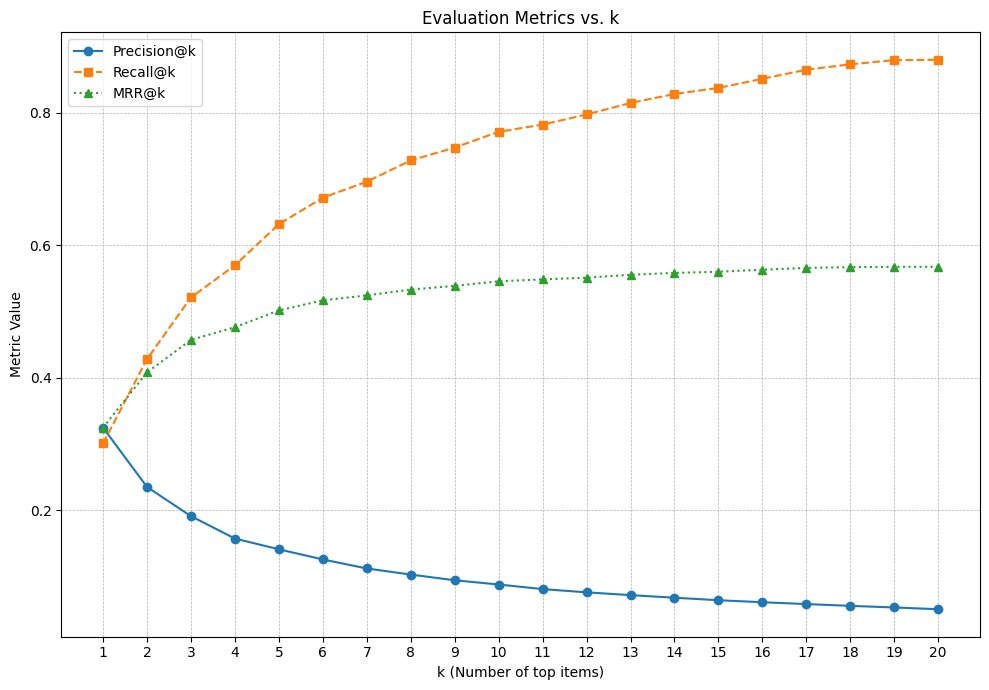

In [68]:
plt.figure(figsize=(10, 7))
plt.plot(k_values, all_precisions, marker='o', linestyle='-', label='Precision@k')
plt.plot(k_values, all_recalls, marker='s', linestyle='--', label='Recall@k')
plt.plot(k_values, all_mrrs, marker='^', linestyle=':', label='MRR@k')

plt.title('Evaluation Metrics vs. k')
plt.xlabel('k (Number of top items)')
plt.ylabel('Metric Value')
plt.xticks(k_values)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()
